In [29]:
import sys
sys.path.append('../')

import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import methods.ax_methods as ax_methods
mpl.rcParams.update(mpl_configs)
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

In [30]:
import scipy.ndimage.filters as ndif
def running_mean_uniform_filter1d(x, N):
    return ndif.uniform_filter1d(x, N, mode='reflect', origin=0)



import methods.filter_lineages as fl

# def calc_coarse_grained_lfc_array(freqs0, D0, freqs1, D1, dt, coarse_grain=100):
#     cg_freqs0 = running_mean_uniform_filter1d(freqs0, coarse_grain)
#     cg_freqs1 = running_mean_uniform_filter1d(freqs1, coarse_grain)
#
#     cg_f0, cg_f1 = fl.maxmin_freqs(cg_freqs0, D0, cg_freqs1, D1)
#
#     with np.errstate(divide='ignore'):
#         return np.log( cg_f1/cg_f0 ) / dt

def sliding_window_sum(x, N):
    return np.convolve(x, np.ones(N))[N+1:-N]

def calc_coarse_grained_lfc_array(freqs0, D0, freqs1, D1, dt, coarse_grain=100):
    cg_freqs0 = sliding_window_sum(freqs0, coarse_grain)
    cg_freqs1 = sliding_window_sum(freqs1, coarse_grain)

    cg_f0, cg_f1 = fl.maxmin_freqs(cg_freqs0, D0, cg_freqs1, D1)

    with np.errstate(divide='ignore'):
        return np.log( cg_f1/cg_f0 ) / dt

MEDIA = ['Arabinose', 'Glucose', 'TYG', 'WAX', 'Xylose']

# def calc_coarse_grained_lfc_array2(freqs0, freqs1, dt, coarse_grain=100, pseudofreqs = (1e-7, 1e-7)):
#     mask = np.array(freqs0)+np.array(freqs1) == 0
#
#     pseudofreq_t0, pseudofreq_t1 = pseudofreqs
#     masked_freqs0 = np.ma.masked_array(freqs0, mask) + pseudofreq_t0 #+ rnd.normal(loc=0, scale=pseudofreq_t0/10, size=mask.shape)
#     masked_freqs1 = np.ma.masked_array(freqs1, mask) + pseudofreq_t1 #+ rnd.normal(loc=0, scale=pseudofreq_t1/10, size=mask.shape)
#
#     cg_freqs0 = running_mean_uniform_filter1d(masked_freqs0, coarse_grain)
#     cg_freqs1 = running_mean_uniform_filter1d(masked_freqs1, coarse_grain)
#
#     with np.errstate(divide='ignore'):
#         return np.log( cg_freqs1/cg_freqs0 ) / dt

In [31]:
def group_lineages_on_initial_frequency(freqs, num_groups=1000):
    sorted_indices = np.argsort(freqs)
    sorted_freqs = freqs[sorted_indices]

    index_groups = []
    cumsum_freqs = np.cumsum(sorted_freqs)
    start = 0
    i = 1
    while start <= cumsum_freqs.shape[0]-1:
        try:
            end = int(np.where(cumsum_freqs <= i/num_groups)[0][-1]) + 1
        except:
            end = cumsum_freqs.shape[0] + 1
        index_groups.append( sorted_indices[start:end] )
        start = end
        i += 1
    return index_groups
# group_lineages_on_initial_frequency(np.array([0.05, 0.05, 0.1, 0.2, 0.4, 0.1, 0.1]), num_groups=3)

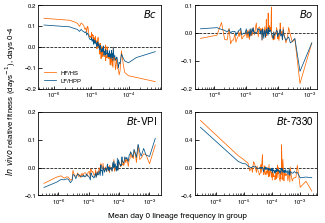

In [35]:
fig = plt.figure(figsize=(5, 3.5))
outer = mpl.gridspec.GridSpec(nrows=3, ncols=3, width_ratios=[1,0.01,1], height_ratios=[1,0.01,1], figure=fig)

outer_ax = fig.add_subplot(outer[:])
outer_ax.set_ylabel('$\it{In~vivo}$ relative fitness (days$^{-1}$), days 0-4', fontsize=8, labelpad=10)
outer_ax.set_xlabel('Mean day 0 lineage frequency in group', fontsize=8, labelpad=10)
ax_methods.turn_off_ax(outer_ax)
# outer_ax2 = outer_ax.twinx()
# outer_ax2.set_ylabel('day 0 frequency of group', color='grey', fontsize=10, labelpad=25, rotation=-90)
# ax_methods.turn_off_ax(outer_ax2)

bac = 'BWH2'
if 'plot rank order curves, etc':
    min_reads = 5
    gene_nn = False
    cutoff = 10**-6.5
    cg = 100 #coarse_grain

    HF_mice = [1, 2, 3, 5, 6, 7, 8, 9, 10]
    LF_mice = [11, 12, 13, 15, 16, 18, 19]
    # validation_mice = [16, 18, 19]

    # discovery_mice = [11, 12, 13, 15]
    # validation_mice = [16, 18, 19]

    HF_d0, HF_d1 = 0, 4
    HF_dt = HF_d1 - HF_d0
    LF_d0, LF_d1 = 0, 4
    LF_dt = LF_d1 - LF_d0


bac_freqs0 = {bac:[] for bac in BACTERIA}
for b, (bac, n_fit) in enumerate([('BWH2', 20000), ('Bovatus', 10000), ('BtVPI', 10000), ('Bt7330', 4000)]):  # library creation
    if 'generate HF and LF frequencies':
        discovery_reads0, HF_reads1 = fl.get_read_arrays(bac, HF_mice, HF_d0, HF_d1, split_day0=2)
        validation_reads0, LF_reads1 = fl.get_read_arrays(bac, LF_mice, LF_d0, LF_d1, split_day0=1)

        discovery_D0, HF_D1 = discovery_reads0.sum(), HF_reads1.sum()
        discovery_freqs0, HF_freqs1 = discovery_reads0 / discovery_D0, HF_reads1 / HF_D1

        validation_D0, LF_D1 = validation_reads0.sum(), LF_reads1.sum()
        validation_freqs0, LF_freqs1 = validation_reads0 / validation_D0, LF_reads1 / LF_D1


        index_groups = group_lineages_on_initial_frequency(discovery_freqs0, num_groups=100)
        freq0_sorted_indices = np.argsort(discovery_freqs0)

        cg_v0 = np.array([validation_freqs0[group].sum() for group in index_groups])
        cg_LF = np.array([LF_freqs1[group].sum() for group in index_groups])
        cg_HF = np.array([HF_freqs1[group].sum() for group in index_groups])

        cg_lfcs_HF = np.log(cg_HF / cg_v0) / 4
        cg_lfcs_LF = np.log(cg_LF / cg_v0) / 4

        mean_v0 = np.array([np.mean(validation_freqs0[group]) for group in index_groups])
        median_v0 = np.array([np.mean(validation_freqs0[group]) for group in index_groups])

    if 'plot':
        ax = fig.add_subplot(outer[2*(b//2), 2*(b%2)])
        ax.plot(mean_v0, cg_lfcs_HF, color=DIET_COLORS['HF'])
        ax.plot(mean_v0, cg_lfcs_LF, color=DIET_COLORS['LF'])
        ax.set_zorder(10)
        ax.patch.set_visible(False)
        ax.axhline(0, color='black', linestyle='dashed', zorder=0)
        ax.set_xscale('log')
        if bac == 'BWH2':
            ax.set_ylim(-0.2, 0.2)
        elif bac == 'Bovatus':
            ax.set_ylim(-0.2, 0.1)
        elif bac == 'BtVPI':
            ax.set_ylim(-0.1, 0.2)
        else:
            ax.set_ylim(-0.4, 0.8)
            ax.set_yticks([-0.4, 0.0, 0.4, 0.8])
        ax.tick_params(axis='both', labelsize=6)

        legend_markers = [ax_methods.make_marker_obj(color=c) for c in [DIET_COLORS['HF'], DIET_COLORS['LF']]]
        legend_labels = ['HF/HS', 'LF/HPP']
        if bac == 'BWH2':
            ax.legend(legend_markers, legend_labels, loc=3, frameon=False)
        # if bac == 'BtVPI':
        ax.text(0.97, 0.85, BAC_FORMAL_NAMES[bac], transform=ax.transAxes,
                horizontalalignment='right', fontsize=10)

        # ax2 = ax.twinx()
        # ax2.plot(mean_v0, cg_v0, color='grey', zorder=0)
        # ax2.set_ylim(0, ax2.get_ylim()[1])
        # ax2.tick_params(axis='y', color='grey', labelcolor='grey')

fig.savefig(f'{biorxiv}/SI_library_vivo_tradeoff.pdf')
